In [ ]:
pip install pandas numpy scikit-learn sqlalchemy boto3 sagemaker imbalanced-learn


In [ ]:
!pip install xgboost

In [ ]:
pip install python-dotenv

In [ ]:
pip install pymysql

In [ ]:
pip install seaborn

In [ ]:
pip install imbalanced-learn

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import pymysql
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import boto3
from io import StringIO
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
import joblib  

print("Todas as bibliotecas foram importadas com sucesso!")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Todas as bibliotecas foram importadas com sucesso!


In [10]:
# Configurações do S3 

BUCKET_URI = "s3://s3sagemakermo/Modelofinal/"
BUCKET_NAME = "s3sagemakermo"
TARGET_NAME = "label_avg_price_per_room"

In [16]:
# Carrega as variáveis de ambiente do arquivo .env
load_dotenv()

# Configurações de conexão com o banco de dados
host = os.getenv('DB_HOST')
port = int(os.getenv('DB_PORT'))
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
database = os.getenv('DB_NAME')

# Criação do engine para conectar ao banco de dados
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

# Carregar dados do banco de dados
try:
    query = "SELECT * FROM base_hotel"  # nome da tabela 
    base_hotel = pd.read_sql_query(query, engine)
except Exception as e:
    print(f"Erro ao conectar ou executar a consulta: {e}")

# Exibir o DataFrame (sem usar print)
base_hotel.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [20]:
base_hotel.isnull().sum() #verificação de valores nulos 

label_avg_price_per_room      0
no_of_adults                  0
no_of_children                0
no_of_weekend_nights          0
no_of_week_nights             0
type_of_meal_plan             0
required_car_parking_space    0
room_type_reserved            0
lead_time                     0
arrival_year                  0
arrival_month                 0
market_segment_type           0
no_of_special_requests        0
dtype: int64

In [21]:
# Função para classificar o preço
def classify_price(price):
    if price <= 85:
        return 0

    elif price > 85 and price < 115:
        return 1
    else:
        return 2

In [18]:
# Criar a coluna de label
base_hotel['label_avg_price_per_room'] = base_hotel['avg_price_per_room'].apply(classify_price)

# Remover a coluna avg_price_per_room
base_hotel = base_hotel.drop(columns=['avg_price_per_room'])

# Lista de colunas que você deseja remover
colunas_para_remover = ['Booking_ID', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 
                        'no_of_previous_bookings_not_canceled', 'booking_status']

# Remover colunas indesejadas
base_hotel.drop(columns=colunas_para_remover, inplace=True)

# Reorganizar as colunas para que 'label_avg_price_per_room' seja a primeira
columns_order = ['label_avg_price_per_room'] + [col for col in base_hotel.columns if col != 'label_avg_price_per_room']
base_hotel = base_hotel[columns_order]

# Nome da nova tabela
table_name = 'base_hotel_modified'

# Salvar o DataFrame em uma nova tabela no banco de dados
base_hotel.to_sql(name=table_name, con=engine, if_exists='replace', index=False)
print(f"Tabela '{table_name}' criada e salva com sucesso no banco de dados.")


Tabela 'base_hotel_modified' criada e salva com sucesso no banco de dados.


In [22]:
# Extrair as features (X) e o target (Y)
X = base_hotel.iloc[:, 1:].values  # Seleciona todas as colunas exceto a primeira para X
Y = base_hotel.iloc[:, 0].values   # Seleciona a primeira coluna (label_avg_price_per_room) para Y

# Codificação das variáveis categóricas
label_encoders = {} # Dicionário para armazenar os codificadores de rótulo
for i, column in enumerate(base_hotel.columns[1:], start=1): 
    if base_hotel[column].dtype == 'object': # Verifica se a coluna é categórica
        le = LabelEncoder() # Cria um codificador de rótulo
        X[:, i-1] = le.fit_transform(X[:, i-1]) # Codifica a coluna categórica
        label_encoders[column] = le # Armazena o codificador no dicionário

# Converte X para float32
X = np.array(X).astype('float32')

# Dividir o conjunto de dados em treinamento e teste
X_treinamento, X_teste, Y_treinamento, Y_teste = train_test_split(X, Y, test_size=0.3, random_state=0)

# Imprimir as colunas que serão usadas como features
colunas_features = base_hotel.columns[1:]  # Exclui a coluna 'label_avg_price_per_room'
print("Colunas que o modelo precisará que sejam preenchidas:")
print(colunas_features)

Colunas que o modelo precisará que sejam preenchidas:
Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'market_segment_type', 'no_of_special_requests'],
      dtype='object')


In [23]:
# Salvar os conjuntos de treinamento e teste como CSV
pd.DataFrame(X_treinamento).to_csv('X_treinamento.csv', index=False)
pd.DataFrame(X_teste).to_csv('X_teste.csv', index=False)
pd.DataFrame(Y_treinamento).to_csv('Y_treinamento.csv', index=False)
pd.DataFrame(Y_teste).to_csv('Y_teste.csv', index=False)

# Imprimir uma amostra dos conjuntos de treinamento e teste
print("Amostra de X_treinamento:")
print(pd.DataFrame(X_treinamento).head())

print("\nAmostra de Y_treinamento:")
print(pd.DataFrame(Y_treinamento).head())

print("\nAmostra de X_teste:")
print(pd.DataFrame(X_teste).head())

print("\nAmostra de Y_teste:")
print(pd.DataFrame(Y_teste).head())

Amostra de X_treinamento:
    0    1    2    3    4    5    6      7       8     9    10   11
0  2.0  0.0  2.0  1.0  3.0  0.0  0.0   89.0  2018.0   4.0  4.0  1.0
1  2.0  0.0  0.0  2.0  0.0  0.0  0.0  308.0  2018.0  11.0  3.0  0.0
2  1.0  0.0  2.0  1.0  0.0  0.0  0.0   20.0  2018.0   3.0  4.0  0.0
3  2.0  0.0  0.0  5.0  0.0  0.0  0.0  230.0  2018.0   9.0  3.0  1.0
4  2.0  0.0  2.0  2.0  0.0  0.0  0.0   80.0  2018.0   9.0  4.0  0.0

Amostra de Y_treinamento:
   0
0  0
1  0
2  0
3  2
4  2

Amostra de X_teste:
    0    1    2    3    4    5    6      7       8     9    10   11
0  3.0  0.0  2.0  3.0  0.0  0.0  3.0   22.0  2018.0   4.0  4.0  2.0
1  2.0  0.0  0.0  3.0  0.0  0.0  0.0  193.0  2017.0  10.0  3.0  0.0
2  2.0  0.0  0.0  2.0  1.0  0.0  0.0  257.0  2017.0   7.0  3.0  0.0
3  2.0  0.0  2.0  4.0  0.0  0.0  3.0    7.0  2018.0   6.0  4.0  1.0
4  2.0  0.0  0.0  2.0  1.0  0.0  0.0   39.0  2017.0   8.0  3.0  0.0

Amostra de Y_teste:
   0
0  2
1  0
2  1
3  2
4  1


In [26]:
# Configuração dos hiperparâmetros para RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],  # Número de árvores
    'max_depth': [3, 5, 7, 10, 15],  # Profundidade máxima da árvore
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Taxa de aprendizado
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Proporção de amostras usadas para ajustar cada árvore
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Proporção de colunas usadas para ajustar cada árvore
    'gamma': [0, 0.1, 0.2, 0.3],  # Regularização
    'min_child_weight': [1, 2, 3, 4]  # Peso mínimo da criança
}

# Inicializar o classificador XGBoost
model_xgb = xgb.XGBClassifier(
    eval_metric='mlogloss',  # Métrica para problemas de classificação multiclasse
    num_class=len(np.unique(Y))  # Número de classes
)

# Inicializar o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_distributions,
    n_iter=20,  # Número de combinações aleatórias a serem testadas
    scoring='accuracy',
    cv=3,  # Número de folds para cross-validation
    n_jobs=-1,  # Utiliza todos os núcleos do processador
    verbose=1,  # Mostra detalhes sobre o progresso
    random_state=0  # Para reprodutibilidade
)

# Treinar o RandomizedSearchCV
random_search.fit(X_treinamento, Y_treinamento)

# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros encontrados:\n", random_search.best_params_)

# Melhor modelo encontrado
best_model = random_search.best_estimator_

# Fazer previsões
Y_pred_xgb = best_model.predict(X_teste)

# Avaliar o modelo
print("XGBoost Accuracy Score:", accuracy_score(Y_teste, Y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(Y_teste, Y_pred_xgb))

# Verifique as classes únicas no conjunto de teste e previsões
print("Classes únicas no conjunto de teste:", np.unique(Y_teste))
print("Classes únicas nas previsões:", np.unique(Y_pred_xgb))

# Salvar o modelo treinado
joblib.dump(best_model, 'best_xgboost_model.pkl')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Melhores hiperparâmetros encontrados:
 {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
XGBoost Accuracy Score: 0.8416796839106864
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3258
           1       0.80      0.81      0.80      4006
           2       0.87      0.87      0.87      3619

    accuracy                           0.84     10883
   macro avg       0.84      0.84      0.84     10883
weighted avg       0.84      0.84      0.84     10883

Classes únicas no conjunto de teste: [0 1 2]
Classes únicas nas previsões: [0 1 2]


['best_xgboost_model.pkl']

Matriz de Confusão:
 [[2765  424   69]
 [ 359 3237  410]
 [  63  398 3158]]


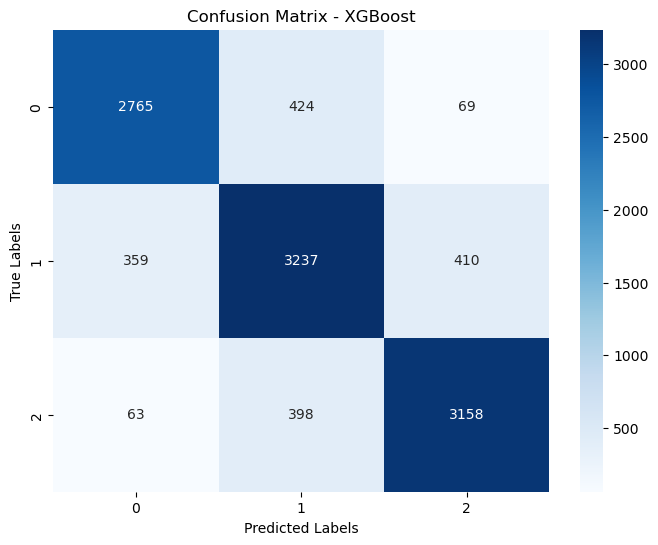

Importância das Features:
                        Feature  Importance
10         market_segment_type    0.214666
6           room_type_reserved    0.173671
8                 arrival_year    0.129483
4            type_of_meal_plan    0.102869
9                arrival_month    0.082295
0                 no_of_adults    0.074103
1               no_of_children    0.064821
7                    lead_time    0.040137
5   required_car_parking_space    0.033058
2         no_of_weekend_nights    0.028756
3            no_of_week_nights    0.028159
11      no_of_special_requests    0.027982


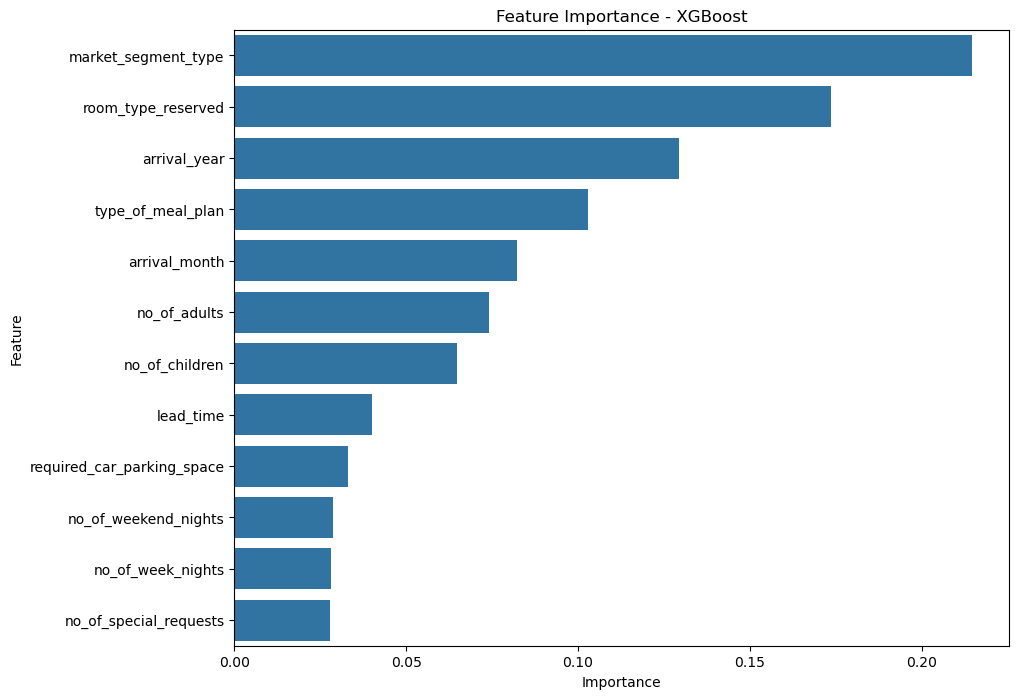

In [28]:
# Importar as bibliotecas necessárias
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# (O restante do código permanece o mesmo)

# Gerar e exibir a matriz de confusão para avaliar o desempenho do modelo
conf_matrix = confusion_matrix(Y_teste, Y_pred_xgb)
print("Matriz de Confusão:\n", conf_matrix)

# Opcional: Exibir a matriz de confusão de forma visual (gráfico)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Gerar a importância das features
importances = best_model.feature_importances_
feature_names = base_hotel.columns[1:]  # Nome das features, excluindo a coluna de label

# Exibir a importância das features
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Importância das Features:\n", feature_importance_df)

# Opcional: Plotar a importância das features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - XGBoost')
plt.show()

In [4]:
import boto3
# Configurar sessão do boto3
s3 = boto3.client('s3')

# Configurações do bucket S3
s3_bucket = 's3sagemakermo'
s3_model_path = 'modelos/best_xgboost_model.pkl'  # Caminho no bucket S3
local_model_path = 'best_xgboost_model.pkl'  # Caminho local do arquivo

# Fazer o upload do arquivo para o bucket S3
try:
    s3.upload_file(local_model_path, s3_bucket, s3_model_path)
    print(f"Modelo enviado para o bucket S3 no caminho: {s3_model_path}")
except Exception as e:
    print(f"Erro ao enviar o arquivo para o bucket S3: {e}")

Modelo enviado para o bucket S3 no caminho: modelos/best_xgboost_model.pkl


# SAGEMAKER 

In [5]:
# Configurar o SageMaker
sess = sagemaker.Session()
bucket = "s3sagemakermo"
subpasta_modelo = 'modelos/hotel-prices/xgboost'
subpasta_dataset = 'datasets/hotel-prices'

key_X_train = 'X_treinamento.csv'
key_X_test = 'X_teste.csv'
key_Y_train = 'Y_treinamento.csv'
key_Y_test = 'Y_teste.csv'

role = get_execution_role()

s3_X_train_data = f's3://{bucket}/{subpasta_dataset}/train/{key_X_train}'
s3_X_test_data = f's3://{bucket}/{subpasta_dataset}/test/{key_X_test}'
s3_Y_train_data = f's3://{bucket}/{subpasta_dataset}/train/{key_Y_train}'
s3_Y_test_data = f's3://{bucket}/{subpasta_dataset}/test/{key_Y_test}'
output_location = f's3://{bucket}/{subpasta_modelo}/output/'

print('Role : {}'.format(role))
print('Localização da base de treinamento X : {}'.format(s3_X_train_data))
print('Localização da base de teste X : {}'.format(s3_X_test_data))
print('Localização da base de treinamento Y : {}'.format(s3_Y_train_data))
print('Localização da base de teste Y : {}'.format(s3_Y_test_data))
print('Modelo final será salvo em : {}'.format(output_location))

# Upload dos arquivos para o S3
s3 = boto3.Session().resource('s3')

with open('X_treinamento.csv', 'rb') as f:
    s3.Bucket(bucket).Object(os.path.join(subpasta_dataset, 'train', key_X_train)).upload_fileobj(f)

with open('X_teste.csv', 'rb') as f:
    s3.Bucket(bucket).Object(os.path.join(subpasta_dataset, 'test', key_X_test)).upload_fileobj(f)

with open('Y_treinamento.csv', 'rb') as f:
    s3.Bucket(bucket).Object(os.path.join(subpasta_dataset, 'train', key_Y_train)).upload_fileobj(f)

with open('Y_teste.csv', 'rb') as f:
    s3.Bucket(bucket).Object(os.path.join(subpasta_dataset, 'test', key_Y_test)).upload_fileobj(f)

Role : arn:aws:iam::767397839645:role/service-role/AmazonSageMaker-ExecutionRole-20240822T110404
Localização da base de treinamento X : s3://s3sagemakermo/datasets/hotel-prices/train/X_treinamento.csv
Localização da base de teste X : s3://s3sagemakermo/datasets/hotel-prices/test/X_teste.csv
Localização da base de treinamento Y : s3://s3sagemakermo/datasets/hotel-prices/train/Y_treinamento.csv
Localização da base de teste Y : s3://s3sagemakermo/datasets/hotel-prices/test/Y_teste.csv
Modelo final será salvo em : s3://s3sagemakermo/modelos/hotel-prices/xgboost/output/


# TREINAMENTO

In [ ]:
pip install --upgrade sagemaker

In [6]:
from sagemaker import image_uris

In [8]:
# Recupera a URI da imagem do XGBoost
container = image_uris.retrieve(framework='xgboost', region=boto3.Session().region_name, version='1.7-1')
print('URI da imagem do XGBoost:', container)

xgboost = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',  # Verifique a instância, por exemplo: ml.m4.xlarge
    output_path=output_location,
    sagemaker_session=sess
)

xgboost.set_hyperparameters(
    subsample=1.0,
    min_child_weight=1,
    max_depth=15,
    learning_rate=0.1,
    gamma=0.2,
    colsample_bytree=0.8,
    num_round=100  
)

# Configurar os dados de entrada para o treinamento
train_input = sagemaker.inputs.TrainingInput(
    s3_data=s3_X_train_data,
    content_type='csv',
    s3_data_type='S3Prefix'
)

validation_input = sagemaker.inputs.TrainingInput(
    s3_data=s3_X_test_data,
    content_type='csv',
    s3_data_type='S3Prefix'
)

# Dicionário de canais de dados
data_channels = {
    'train': train_input,
    'validation': validation_input
}

print('Configuração dos canais de dados:')
print(data_channels)

# Iniciar o treinamento
xgboost.fit(data_channels)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-08-31-17-52-17-764


URI da imagem do XGBoost: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1
Configuração dos canais de dados:
{'train': <sagemaker.inputs.TrainingInput object at 0x7fc094f3d750>, 'validation': <sagemaker.inputs.TrainingInput object at 0x7fc094f3d900>}
2024-08-31 17:52:20 Starting - Starting the training job...
2024-08-31 17:52:35 Starting - Preparing the instances for training...
2024-08-31 17:53:01 Downloading - Downloading input data...
2024-08-31 17:53:26 Downloading - Downloading the training image...
2024-08-31 17:54:17 Training - Training image download completed. Training in progress...[2024-08-31 17:54:28.240 ip-10-0-79-4.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-08-31 17:54:28.264 ip-10-0-79-4.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-08-31:17:54:28:INFO] Imported framework sagemaker_xgboost_container.training
[2024-08-31:17:54:28:INFO] No GPUs detected (normal if no gpus installed)


In [14]:
import boto3

s3_bucket = 's3sagemakermo'
s3_key = 'modelos/hotel-prices/xgboost/output/sagemaker-xgboost-2024-08-31-17-52-17-764/output/model.tar.gz'
local_tar_path = 'model.tar.gz'

s3 = boto3.client('s3')
s3.download_file(s3_bucket, s3_key, local_tar_path)

In [15]:
import tarfile

extracted_model_path = 'xgboost-model'

with tarfile.open(local_tar_path, 'r:gz') as tar:
    tar.extractall(path=extracted_model_path)

In [16]:
import xgboost as xgb

# Carregar o modelo
model_path = f'{extracted_model_path}/xgboost-model'
model = xgb.Booster()
model.load_model(model_path)

# Obter informações sobre o modelo
feature_names = model.feature_names
print("Feature names:", feature_names)

Feature names: None


<Figure size 1000x800 with 0 Axes>

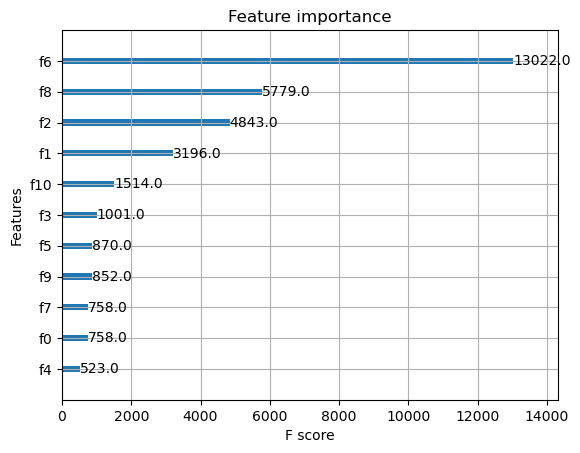

In [17]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o modelo
model_path = f'{extracted_model_path}/xgboost-model'
model = xgb.Booster()
model.load_model(model_path)

# Plotar a importância das características
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight')
plt.show()